In [15]:
import imageio.v3 as iio
import ipympl
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski

We use the iio.imread() function to read a JPEG image entitled
maize-root-cluster.jpg. Imageio reads the image, converts it 
from JPEG into a NumPy array, and returns the array; we 
save the array in a variable named image.

In [16]:
image = iio.imread(uri="maize-root-cluster.jpg")


iio.imwrite() function to save our image in TIFF format in the data directory as roots.tiff.


In [17]:
iio.imwrite("roots.tif", image)

## Manipulating pixels


removing background colour ex: black background


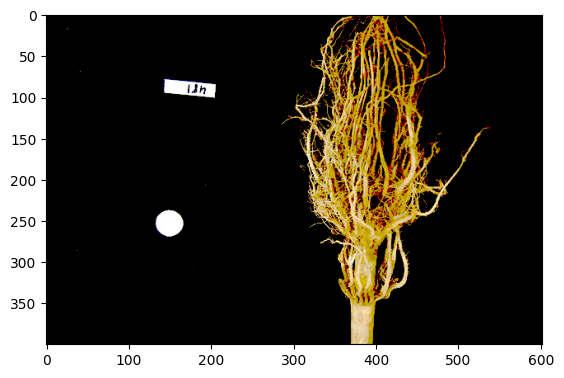

In [18]:
maize_roots = np.array(image)
maize_roots[maize_roots < 128] = 0 #128 = threshold value
plt.imshow(maize_roots)
plt.show()

Converting colour images to grayscale

ski.util.img_as_ubyte() in order to 
convert it back to the original data 
type and the data range back 0 to 255

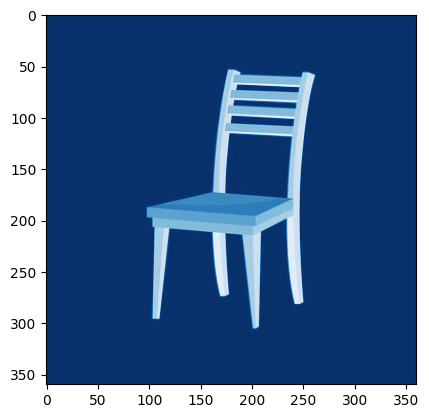

In [19]:
chair = iio.imread(uri="chair.jpg")
gray_chair = ski.color.rgb2gray(chair)
plt.imshow(gray_chair, cmap="Blues")
plt.show()

We can also load colour images as grayscale directly 
by passing the argument mode="L" to iio.imread().

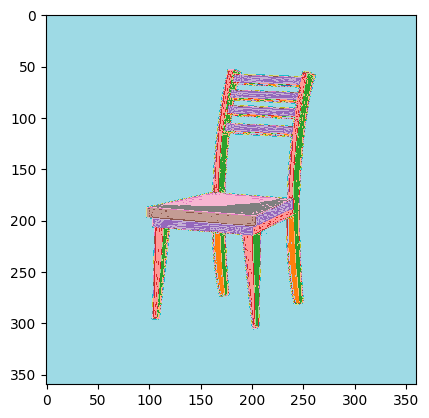

In [20]:
gray_chair = iio.imread(uri="chair.jpg", mode="L")
plt.imshow(gray_chair, cmap="tab20")
plt.show()

## Access via clicing

scikit-image images are stored as NumPy arrays, 
so we can use array slicing to select rectangular
areas of an image. Then, we can save the selection
as a new image, change the pixels in the image, 
and so on. It is important to remember that coordinates
are specified in (ry, cx) order and that colour values 
are specified in (r, g, b) order when doing these manipulations.

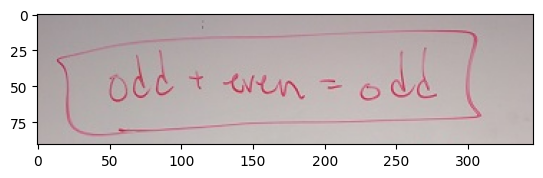

In [21]:
board = iio.imread(uri="board.jpg")
board = np.array(board)
clipped_board = board[60:151, 135:481, :]
plt.imshow(clipped_board)
plt.show()

We can also change the color of the area, which we wanted to clip

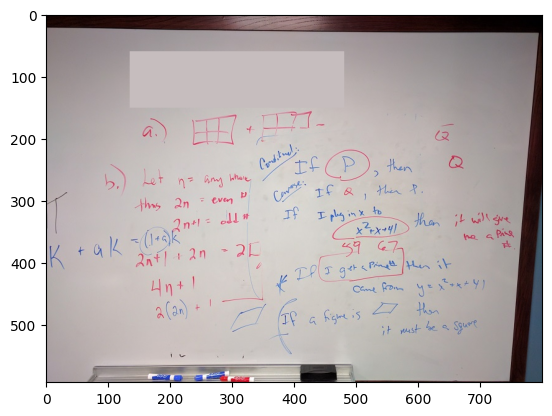

In [22]:
# replace clipped area with sampled color
color = board[330, 90]
board[60:151, 135:481] = color
plt.imshow(board)
plt.show()

## Masking


In many situations in image processing we want to retain or manipulate only some parts of the image. We do that by using masks. Masks are Boolean arrays where the “pixels” in the regions (or patches) of interest are valued True (False) whereas the rest are False (True). The way the pixels (or array elements) of interest are defined varies according to the problem, you can, for instance, define the elements through colour/value selection (like we did when we turned all dark pixels into black “0”), or you can use a pre-defined list of [y,x] positions. If we want to mask a certain region of the image and we want to create a list of the [y,x] elements in that area we can use skimage drawing tools to accomplish that. Suppose we want to retain only the roots of the seeds in the following image:

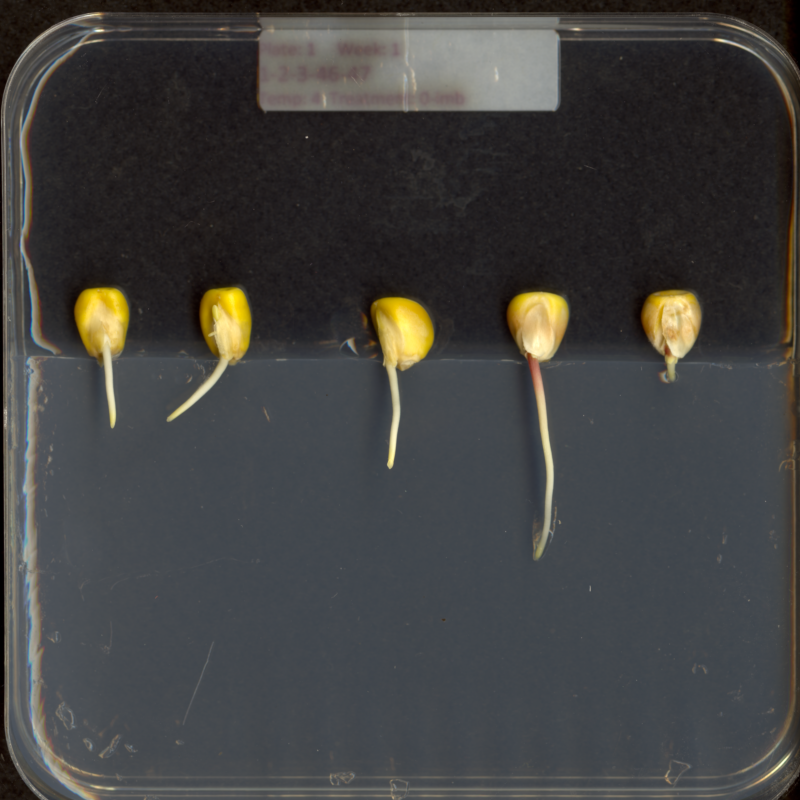

We can define the rectangle covering the region through a mask and manipulate the image as follows:

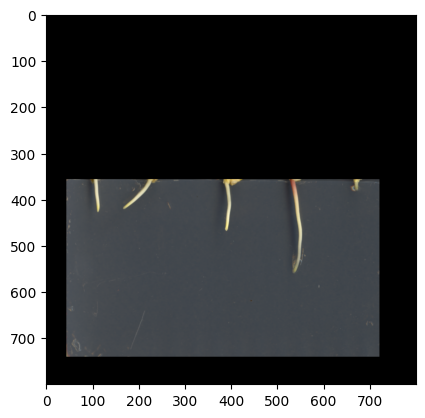

In [23]:
from skimage.draw import rectangle
image = iio.imread(uri="maize-seedlings.tif")
mask = np.ones(image.shape[0:2], dtype=bool)
rr, cc = rectangle(start=(357, 44), end=(740, 720))
mask[rr,cc] = False
image[mask] = 0
plt.imshow(image)
plt.show()

# Histograms and why they are important


Intensity/Colour histograms play an important role in image processing, giving a deeper understanding of image through their light distribution. If your project involves detecting colour changes between images, histograms will prove to be very useful, and histograms are also quite handy as a preparatory step before performing thresholding.

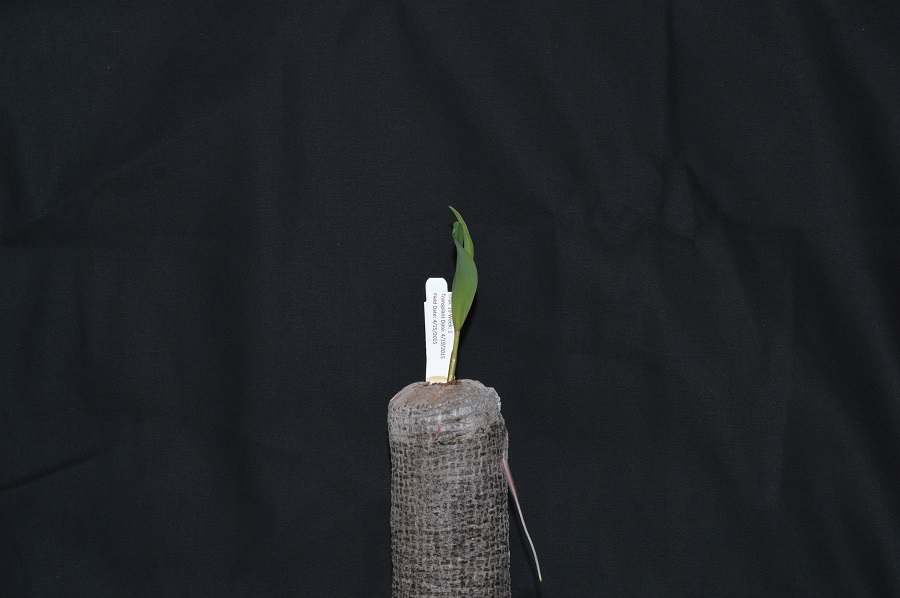

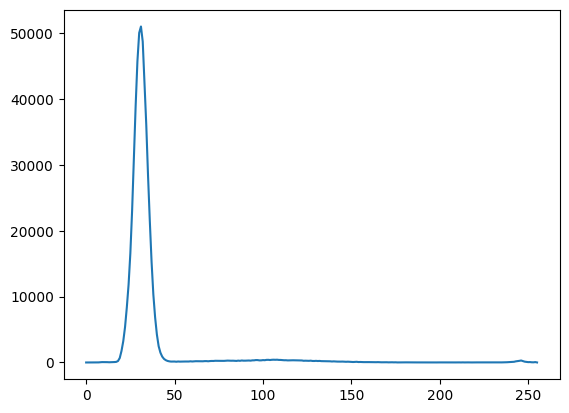

In [24]:
plant_seedling = iio.imread(uri="plant-seedling.jpg", mode="L")
counts, edges = np.histogram(plant_seedling.flatten(), bins=256, range=(0,256))
plt.plot(edges[:-1], counts)
plt.show()

# The mode="L" parameter indicates that the image should be loaded 
# in grayscale mode, meaning it will only have shades of black and
# white, which simplifies the image to a single intensity value per pixel.

We can also use Matplotlib (directly) to plot our image’s histogram:

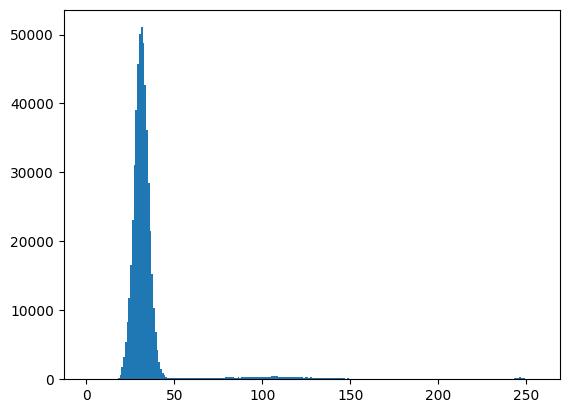

In [25]:
_ = plt.hist(plant_seedling.flatten(), bins=256, range=(0,256))
plt.show()

## Blurring Images

### Gaussian blur: 
smoothes uneven pixel values in an image by cutting out the extreme outliers.

 It works by mixing the colors of each pixel with the colors of nearby pixels. The mixing follows a specific pattern that gives more importance to the colors of pixels closer to the center pixel and less to those farther away. This creates a smooth, blurred effect that looks like the image is slightly out of focus. It’s often used to reduce noise or detail in images, making them look smoother or to create a special visual effect.

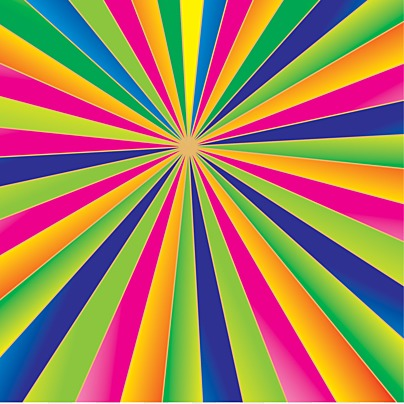

In [26]:
image = iio.imread(uri="gaussian-original.png")

We can apply gaussian blur by using ski.filters.gaussian() function.

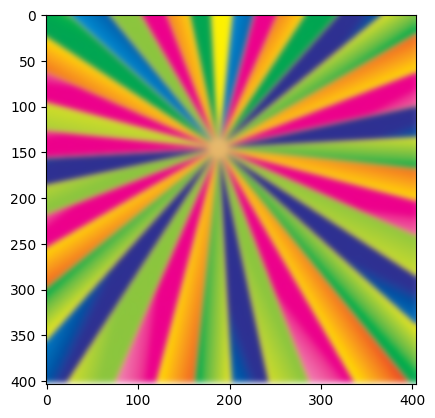

In [27]:
sigma = 3.0
# apply Gaussian blur, creating a new image
blurred = ski.filters.gaussian(image, sigma=(sigma, sigma), truncate=3.5, channel_axis=-1)
plt.imshow(blurred)
plt.show()

The first parameter is the image, and the second is a tuple (sigma, sigma), specifying the blur intensity in both directions. The truncate parameter determines the radius of the kernel as a multiple of sigma; in this example, it's set to 3.5, meaning the kernel size is 2 * sigma * 3.5. For instance, a sigma of 1.0 results in a kernel size of 7. The function's default truncate value is 4.0.

The channel_axis=-1 argument specifies that the color channels are in the last dimension of the image, which is typical for color images in Python, where -1 denotes the last index.

## Thresholding

Thresholding is a type of image segmentation, where we change the pixels of an image to make the image easier to analyze. In thresholding, we convert an image from colour or grayscale into a binary image, i.e., one that is simply black and white. Most frequently, we use thresholding as a way to select areas of interest of an image, while ignoring the parts we are not concerned with.

Consider the image data/shapes-01.jpg with a series of crudely cut shapes set against a white background. Now suppose we want to select only the shapes from the image. In other words, we want to leave the pixels belonging to the shapes “on,” while turning the rest of the pixels “off,” by setting their colour channel values to zeros.

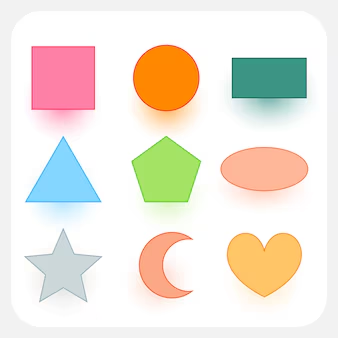

In [28]:
shapes01 = iio.imread(uri="shapes-01.jpg")
# convert the image to grayscale
gray_shapes = ski.color.rgb2gray(shapes01)
# blur the image to denoise
blurred_shapes = ski.filters.gaussian(gray_shapes, sigma=1.0)

We would like to apply the threshold t such that pixels with grayscale values on one side of t will be turned “on”, while pixels with grayscale values on the other side will be turned “off”. Remember that grayscale images contain pixel values in the range from 0 to 1, so we are looking for a threshold t in the closed range [0.0, 1.0]. We see in the image that the geometric shapes are “darker” than the white background but there is also some light gray noise on the background. One way to determine a “good” value for t is to look at the grayscale histogram of the image and try to identify what grayscale ranges correspond to the shapes in the image or the background.

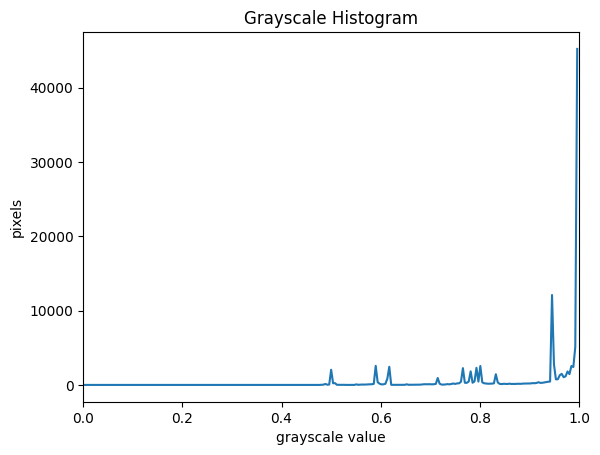

In [29]:
# create a histogram of the blurred grayscale image
histogram, bin_edges = np.histogram(blurred_shapes, bins=256, range=(0.0, 1.0))

fig, ax = plt.subplots()
ax.plot(bin_edges[0:-1], histogram)
ax.set_title("Grayscale Histogram")
ax.set_xlabel("grayscale value")
ax.set_ylabel("pixels")
ax.set_xlim(0, 1.0)
plt.show()

Since the image has a white background, most of the pixels in the image are white. This corresponds nicely to what we see in the histogram: there is a peak near the value of 1.0. If we want to select the shapes and not the background, we want to turn off the white background pixels, while leaving the pixels for the shapes turned on. So, we should choose a value of t somewhere before the large peak and turn pixels above that value “off”. Let us choose t=0.8.

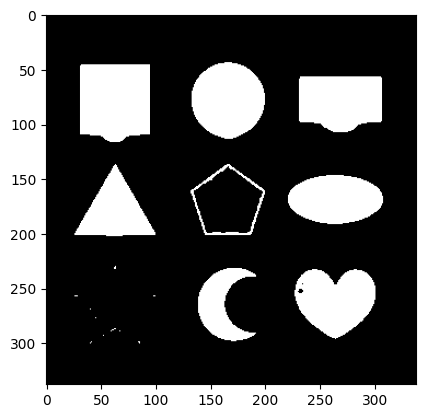

In [30]:
# create a mask based on the threshold
t = 0.8
binary_mask = blurred_shapes < t
fig, ax = plt.subplots()
ax.imshow(binary_mask, cmap="gray")
plt.show()

## Otsu's method

situations where the grayscale histogram of an image has two peaks that correspond to background and objects of interest.

The Otsu’s method automates the process of defining “t” by looking for the (intensity) value that maximizes the information on each class.

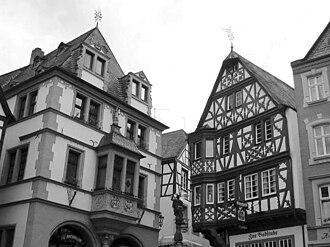

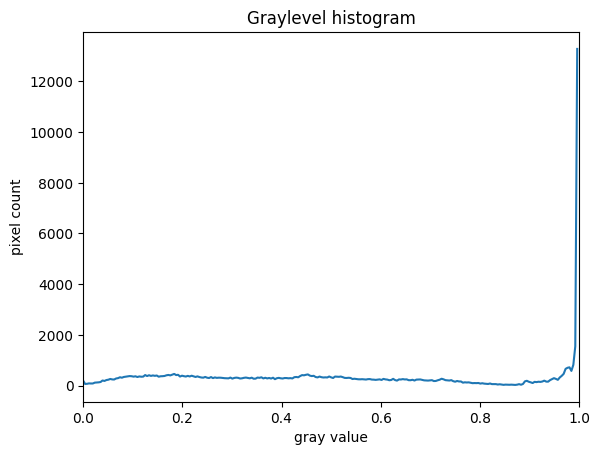

In [31]:
image = iio.imread("otsu_image.jpg", mode="L")
# blur the image to denoise
blurred_image = ski.filters.gaussian(image, sigma=.00001)

# show the histogram of the blurred image
histogram, bin_edges = np.histogram(blurred_image, bins=256, range=(0.0, 1.0))
plt.plot(bin_edges[0:-1], histogram)
plt.title("Graylevel histogram")
plt.xlabel("gray value")
plt.ylabel("pixel count")
plt.xlim(0, 1.0)
plt.show()

Here, we can see that it's difficult to identify the correct value of t. In order to find it, let's use Otsu's method.

In [32]:
from skimage.filters import threshold_otsu

Optimal value for t: 0.595703125


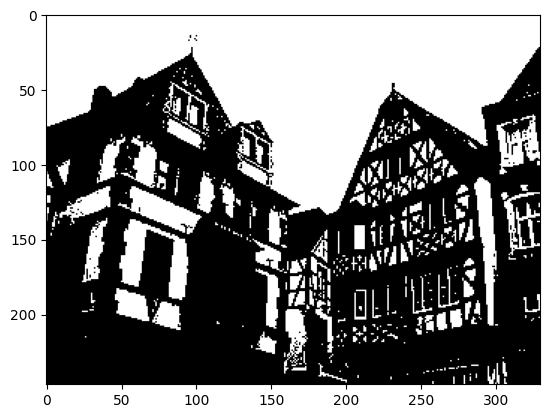

In [33]:
t = threshold_otsu(blurred_image)
print(f'Optimal value for t: {t}')
mask = blurred_image > t
plt.imshow(mask, cmap="gray")
plt.show()

# Object identification

In [34]:
shapes01 = iio.imread(uri="shapes-01.jpg")
# convert the image to grayscale
gray_shapes = ski.color.rgb2gray(shapes01)
# blur the image to denoise
blurred_shapes = ski.filters.gaussian(gray_shapes, sigma=1.0)
# define the threshold
t = 0.8
# create a binary_mask
binary_mask = blurred_shapes < t

In order to find number of objects on the picture, let's use ski.measure.label() with different number of connectivities.

  connectivity = 1:

Number of objects on the image: 21


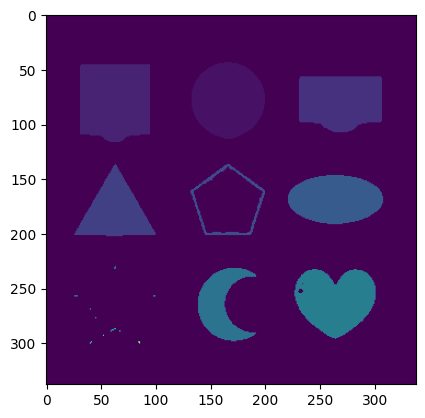

In [35]:
labeled_image, count = ski.measure.label(binary_mask, connectivity=1, return_num=True)
print(f'Number of objects on the image: {count}')
plt.imshow(labeled_image)
plt.show()

We see that by using 1-Jump / 4-Neighborhood we identified 12 objects

  connectivity = 2:

Number of objects on the image: 18


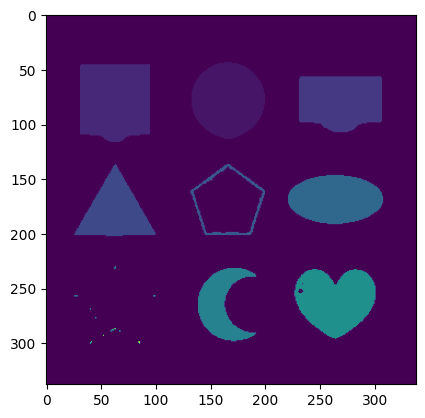

In [73]:
labeled_image, count = ski.measure.label(binary_mask, connectivity=2, return_num=True)
print(f'Number of objects on the image: {count}')
plt.imshow(labeled_image)
plt.show()


In [74]:
# compute object features and extract object areas
object_features = ski.measure.regionprops(labeled_image)
object_areas = [objf["area"] for objf in object_features]
object_areas

[3630.0,
 4248.0,
 3446.0,
 2507.0,
 484.0,
 3051.0,
 5.0,
 1821.0,
 3370.0,
 3.0,
 2.0,
 1.0,
 1.0,
 5.0,
 1.0,
 1.0,
 2.0,
 3.0]